In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys
from copy import deepcopy
import itertools

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

from hydra import initialize

import matplotlib.pyplot as plt
import numpy as np
import supervision as sv
import torch
from torch.amp import autocast
from torchvision.transforms import ToPILImage, Normalize, Resize
from torchmetrics.detection import PanopticQuality
from training.dataset.transforms import ComposeAPI, NormalizeAPI

from helpers.configurations import TRACK_TO_METAINFO, LABEL_PROJECTION_MAP
from dataset.collate_fn import collate_fn, collate_fn_wrapper
from dataset.mini_dataset import MiniDataset
from custom_model_builder import build_sam2former

/home/guests/tuna_gurbuz/prototype


In [3]:
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().is_initialized()

False

In [4]:
config

Available objects for config:
    AliasManager
    DisplayFormatter
    HistoryManager
    IPCompleter
    IPKernelApp
    LoggingMagics
    MagicsManager
    OSMagics
    PrefilterManager
    ScriptMagics
    StoreMagics
    ZMQInteractiveShell


In [5]:
model_size_dict = {
    # 'base': {
    #     'config': '04_28_00_50/config_resolved.yaml',
    #     'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/04_28_00_50/checkpoints/checkpoint_33.pt',
    #     },
    # 'base': {
    #     'config': '05_24_10_21/config_resolved.yaml',
    #     'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/05_24_10_21/checkpoints/checkpoint_34.pt',
    #     },
    'base1': {
        'config': '06_27_17_54/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_12_10_18/checkpoints/checkpoint_50.pt',
        },
    'base2': {
        'config': '07_12_10_18_def2/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_12_10_18_def2/checkpoints/checkpoint_51.pt',
        },
    'base3': {
        'config': '07_17_21_33/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_17_21_33/checkpoints/checkpoint_65.pt',
        },
    'base4': {
        'config': '07_25_11_08/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_26_09_10/checkpoints/checkpoint_69.pt',
        },
    'base5': {
        'config': '07_26_09_10/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_26_09_10/checkpoints/checkpoint_75.pt',
        },
    'base6': {
        'config': '07_28_08_49/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_28_08_49/checkpoints/checkpoint_83.pt',
        },
    'base7': {
        'config': '07_29_16_47/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/07_29_16_47/checkpoints/checkpoint_56.pt',
        },
    'base8': {
        'config': '08_03_21_22/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/08_03_21_22/checkpoints/checkpoint_30.pt',
        },
    'base9': {
        'config': '08_20_11_39/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/08_20_11_39/checkpoints/checkpoint_24.pt',
        },
    'base10': {
        'config': '09_01_14_53_MV/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/09_01_14_53_MV/checkpoints/checkpoint_3.pt',
        },
    'base11': {
        'config': '09_11_18_13_MV/config_resolved.yaml',
        'ck': '/home/guests/tuna_gurbuz/prototype/sam2_logs/09_11_18_13_MV/checkpoints/checkpoint_3.pt',
        },
}
# Model
model_size = 'base11'
config = model_size_dict[model_size]['config']
ck = model_size_dict[model_size]['ck']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# Hydra init
config_path = f'../sam2_logs/{config.split("/")[0]}/'
print("Config path:", config_path)
config = config.split('/')[1]
try:
    initialize(version_base=None, config_path=config_path, job_name="predict_run")
except ValueError:
    pass
hydra_overrides = ['scratch.multiview=true', 'trainer.model.multiview=true']
amp_type = torch.bfloat16 if device == 'cuda' else torch.float16
submodel, object_labels, _, loss, mean, std = build_sam2former(config, ck, device=device, hydra_overrides_extra=hydra_overrides)
print(device)

Config path: ../sam2_logs/09_11_18_13_MV/
OmegaConf resolved successfully


Frequency file exists. Using weights from frequency file
Using log loss weighting...
Frequency file exists. Using weights from frequency file
Using log loss weighting...
cuda


In [6]:
# submodel.multiview, submodel.epipolar_encoder

In [7]:
for ii in range(6):
    before = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    # print("before", before)
    print(torch.all(before == 0))
sd = torch.load(ck, map_location="cpu", weights_only=True)["model"]
missing_keys, unexpected_keys = submodel.load_state_dict(sd, strict=False)
for ii in range(6):
    after = submodel.sam_mask_decoder.pixel_decoder.transformer.encoder.layers[ii].self_attn.attention_weights.weight
    # print("after", after)
    print(torch.all(after == 0))

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [8]:
missing_keys, unexpected_keys

([], [])

In [9]:
# Dataset
BACKGROUND=23
len_video = 1
input_image_size = 256
batch_size = 1
shuffle = False
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# revert_mean=[-.485/.229, -.456/.224, -.406/.225]
# revert_std=[1/.229, 1/.224, 1/.225]
#####
# mean = [0.3551, 0.3500, 0.3469]
# std = [0.2921, 0.2716, 0.2742]
# revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
# revert_std=[1/.2921, 1/.2716, 1/.2742]
#####
revert_mean = [-mean[0]/std[0], -mean[1]/std[1], -mean[2]/std[2]]
revert_std = [1/std[0], 1/std[1], 1/std[2]]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('test',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           multiview=True,
                           depth_image=True,
                           collate_fn=collate_fn_wrapper,
                           batch_size=batch_size,
                           get_seg_mask=True,
                           shuffle=shuffle,)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 004_PKA!


3218it [00:01, 2656.33it/s]


Mutual IDs: 825
Loading the take 011_TKA!


3128it [00:01, 1922.21it/s]


Mutual IDs: 688
Loading the take 036_PKA!


4384it [00:02, 1747.28it/s]


Mutual IDs: 990
Loading the take 038_TKA!


2876it [00:01, 2038.44it/s]


Mutual IDs: 638
Lenght of the dataset! 3141


In [10]:
seed = 2 # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
if_break = False
# sample_idx = 950
# sample_idx = 2000
# sample_idx = 1250
# # sample_idx = 3993
# sample_idx = 278
# sample_idx = 500
# sample_idx = 279
# sample_idx = 872
sample_idx = 300
sample_idx = 370
# test_loader = test_dataset.get_loader()
flag_iter = False

# Run the model
with torch.no_grad():
    submodel.eval()
    if flag_iter:
        batch = next(itertools.islice(test_loader, sample_idx, None))
    else:
        batch = [test_dataset[i] for i in range(sample_idx * batch_size, (sample_idx+1) * batch_size) if i < len(test_dataset)]
        batch = collate_fn_wrapper(batch, len_video, 'val')
    batched_video_data_val = batch.to(device)
    # batch_seg_mask_gt = batch[1]  # List of PIL Image for debug
    masks_val0 = batch[0].masks.to(device)
    masks_val1 = batch[1].masks.to(device)
    masks_val2 = batch[2].masks.to(device)
    with autocast(device_type=device, dtype=amp_type):
        all_frame_outputs_val = submodel(batched_video_data_val)

In [11]:
[test_dataset.images[i] for i in range(sample_idx * batch_size, (sample_idx+1) * batch_size)]

[[PosixPath('/home/polyaxon-data/data1/MM-OR_processed/004_PKA/colorimage/camera04_colorimage-000993.jpg')]]

In [12]:
all_frame_outputs_val.keys(), all_frame_outputs_val[0].keys(), all_frame_outputs_val[0][0].keys()

(dict_keys([0, 1, 2]),
 dict_keys([0]),
 dict_keys(['pred_masks', 'pred_masks_high_res', 'pred_logits', 'aux_outputs']))

In [13]:
def process_outputs(view_output, unique_object_identfier):
    # Convert mask prediction logits to binary masks
    binary_pred_masks = view_output[0]['pred_masks_high_res'].sigmoid() > 0.5
    binary_pred_masks = binary_pred_masks.cpu().numpy()

    # Convert class logits to class predictions
    pred_logits = view_output[0]['pred_logits'].type(torch.float32).softmax(-1).cpu().numpy()
    pred_class = pred_logits.argmax(-1)

    gt_labels = unique_object_identfier[:,:,1]
    return binary_pred_masks, pred_class, gt_labels

binary_pred_masks0, pred_class0, gt_labels0 = process_outputs(all_frame_outputs_val[0], batched_video_data_val[0].metadata.unique_objects_identifier)
binary_pred_masks1, pred_class1, gt_labels1 = process_outputs(all_frame_outputs_val[1], batched_video_data_val[1].metadata.unique_objects_identifier)
binary_pred_masks2, pred_class2, gt_labels2 = process_outputs(all_frame_outputs_val[2], batched_video_data_val[2].metadata.unique_objects_identifier)

B, N, H, W = binary_pred_masks0.shape  # Size with padding

In [14]:
# import json
# dump_dict = {k: v.cpu().type(torch.float32).numpy().tolist() for k,v in all_frame_outputs_val[0].items() if k != 'aux_outputs'}
# with open('../temp/predictions.json', 'w') as f:
#     json.dump(dump_dict, f)

In [15]:
pred_class0, gt_labels0

(array([[15,  9,  3,  2,  7, 13, 16,  7, 19, 17,  5,  8, 14, 18,  1,  8,
         14,  6, 10,  0, 11,  4, 12]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22]], device='cuda:0'))

In [16]:
def get_color_map():
    color_map = {}
    for k, v in LABEL_PROJECTION_MAP['default'].items():
        # if k > 7 and v['label'] == 6:
        #     continue
        r, g, b = v['color']
        color_map[v['label']] = (r,g,b)
    return color_map

# Get color map
color_map = get_color_map()

In [17]:
def _prepare_seg_rgb_masks(binary_pred_masks, pred_class, color_map, manip=False):
    """
    Prepare segmentation mask and RGB mask with color encoding.
    """
    B, H, W = binary_pred_masks.shape[0], binary_pred_masks.shape[2], binary_pred_masks.shape[3]
    pred_seg_class_mask = np.ones((B, 1, H, W), dtype=np.int8) * 23  # 16 is the background class
    pred_rgb_mask = np.zeros((B, H, W, 3), dtype=np.uint8)
    
    for _b_idx, (_b_binary_pred_masks, _b_pred_class) in enumerate(zip(binary_pred_masks, pred_class)):
        for mask, class_id in zip(_b_binary_pred_masks, _b_pred_class):
            if class_id == BACKGROUND:
                continue
            pos = np.where(mask == True)
            if len(pos[0]) > 0:
                pred_seg_class_mask[_b_idx, 0, pos[0], pos[1]] = class_id
                if manip:
                    color = color_map[class_id] if class_id != 10 else color_map[17]
                else:
                    color = color_map[class_id]
                pred_rgb_mask[_b_idx, pos[0], pos[1], :] = color
            else:
                continue
    return pred_seg_class_mask, pred_rgb_mask

pred_seg_class_mask0, pred_rgb_mask0 = _prepare_seg_rgb_masks(binary_pred_masks0, pred_class0, color_map)
pred_seg_class_mask1, pred_rgb_mask1 = _prepare_seg_rgb_masks(binary_pred_masks1, pred_class1, color_map)
pred_seg_class_mask2, pred_rgb_mask2 = _prepare_seg_rgb_masks(binary_pred_masks2, pred_class2, color_map)

In [18]:
def _prepare_gt_seg_rgb_masks(masks_val, gt_labels, obj_to_frame_idx, color_map):
    """
    Prepare ground truth segmentation mask and RGB mask with color encoding.
    """
    B, H, W = masks_val.shape[0], masks_val.shape[2], masks_val.shape[3]
    # Initialize masks
    gt_seg_class_mask = np.ones((B, 1, H, W), dtype=np.int8) * 23  # 16 is the background class
    gt_rgb_mask = np.zeros((B, H, W, 3), dtype=np.uint8)
    for batch_idx in range(B):
        pos = obj_to_frame_idx[0,:,1] == batch_idx  # The objects in the batch are mixed
        gt_mask = masks_val[0, pos, :, :].cpu().numpy()  # Get the GT masks in the batch
        gt_class_id = gt_labels[0, pos].cpu().numpy()  # Get the GT class id in the batch
        for mask, class_id in zip(gt_mask, gt_class_id):
            pos = np.where(mask == True)
            if len(pos[0]) > 0:
                gt_seg_class_mask[batch_idx, 0, pos[0], pos[1]] = class_id
                gt_rgb_mask[batch_idx, pos[0], pos[1], :] = color_map[class_id]
            else:
                continue
    return gt_seg_class_mask, gt_rgb_mask

gt_seg_class_mask0, gt_rgb_mask0 = _prepare_gt_seg_rgb_masks(masks_val0, gt_labels0, batched_video_data_val[0].obj_to_frame_idx, color_map)
gt_seg_class_mask1, gt_rgb_mask1 = _prepare_gt_seg_rgb_masks(masks_val1, gt_labels1, batched_video_data_val[1].obj_to_frame_idx, color_map)
gt_seg_class_mask2, gt_rgb_mask2 = _prepare_gt_seg_rgb_masks(masks_val2, gt_labels2, batched_video_data_val[2].obj_to_frame_idx, color_map)

### Color encoded segmentation masks and label encoded segmentation masks

In [19]:
pred_rgb_mask0.shape, pred_seg_class_mask0.shape, gt_rgb_mask0.shape, gt_seg_class_mask0.shape

((1, 256, 256, 3), (1, 1, 256, 256), (1, 256, 256, 3), (1, 1, 256, 256))

In [20]:
# Check if the image is black (0,0,0) along the height dimension
ref_img = batched_video_data_val[0][0].img_batch[0].cpu().numpy()
is_black_row = (ref_img[0,:,:] <= 0)  # Check along width and channels
pos_padding = np.where(is_black_row == False)
start = pos_padding[0][0]
end = pos_padding[0][-1]
start

32

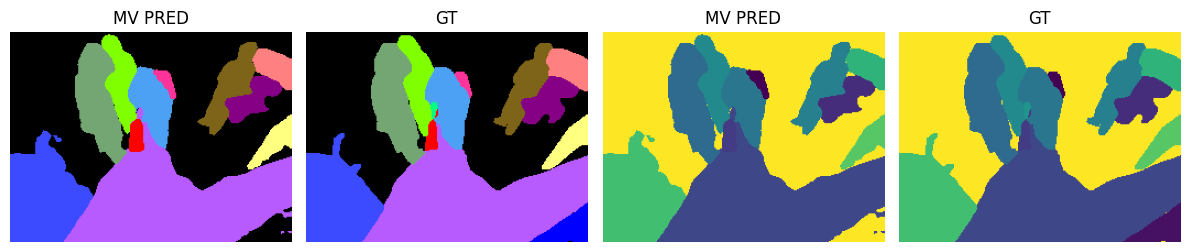

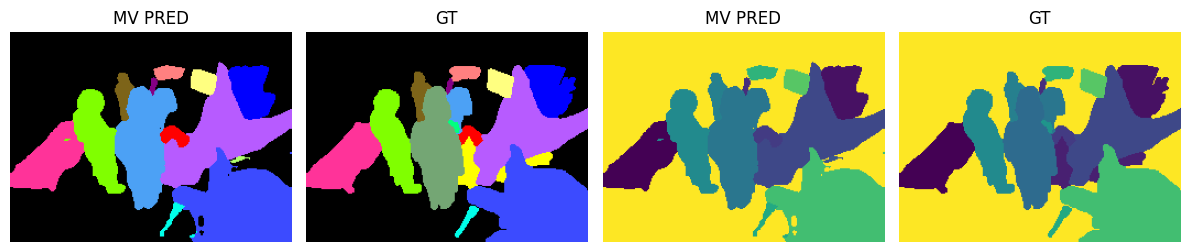

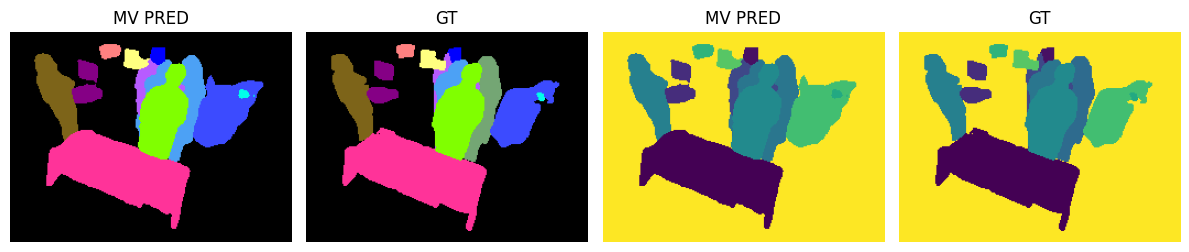

In [21]:
def visualize_masks(pred_rgb_mask, gt_rgb_mask, pred_seg_class_mask, gt_seg_class_mask):
    """
    Visualize the predicted and ground truth masks.
    """
    B = pred_rgb_mask.shape[0]
    figsize = np.array([4, B]) * 3
    fig, axs = plt.subplots(B, 4, figsize=figsize)

    if B == 1:
        axs = np.expand_dims(axs, axis=0)
    for ii in range(B):
        axs[ii,0].imshow(pred_rgb_mask[ii])
        axs[ii,0].axis('off')
        axs[ii,0].set_title('MV PRED')

        axs[ii,1].imshow(gt_rgb_mask[ii])
        axs[ii,1].axis('off')
        axs[ii,1].set_title('GT')

        axs[ii,2].imshow(pred_seg_class_mask[ii, 0])
        axs[ii,2].axis('off')
        axs[ii,2].set_title('MV PRED')

        axs[ii,3].imshow(gt_seg_class_mask[ii, 0])
        axs[ii,3].axis('off')
        axs[ii,3].set_title('GT')

    plt.tight_layout()
    plt.show()

visualize_masks(pred_rgb_mask0[:, start:end], gt_rgb_mask0[:, start:end], pred_seg_class_mask0[:, :, start:end], gt_seg_class_mask0[:, :, start:end])
visualize_masks(pred_rgb_mask1[:, start:end], gt_rgb_mask1[:, start:end], pred_seg_class_mask1[:, :, start:end], gt_seg_class_mask1[:, :, start:end])
visualize_masks(pred_rgb_mask2[:, start:end], gt_rgb_mask2[:, start:end], pred_seg_class_mask2[:, :, start:end], gt_seg_class_mask2[:, :, start:end])

# figsize = np.array([4, B]) * 3
# fig, axs = plt.subplots(B, 4, figsize=figsize, )

# for ii in range(B):
#     axs[ii,0].imshow(pred_rgb_mask[ii])
#     axs[ii,0].axis('off')
#     axs[ii,0].set_title('PRED')

#     axs[ii,1].imshow(gt_rgb_mask[ii])
#     axs[ii,1].axis('off')
#     axs[ii,1].set_title('GT')

#     axs[ii,2].imshow(pred_seg_class_mask[ii, 0])
#     axs[ii,2].axis('off')
#     axs[ii,2].set_title('PRED')

#     axs[ii,3].imshow(gt_seg_class_mask[ii, 0])
#     axs[ii,3].axis('off')
#     axs[ii,3].set_title('GT')

# plt.tight_layout()
# plt.show()

### Calculate Panoptic Quality (PQ)

In [22]:
# Stuff: 16, Things: 17 Instance labels: 0-15
background = BACKGROUND
things = {LABEL_PROJECTION_MAP['default'][idx]['label'] for idx in object_labels}
stuff = {background}  # Putting 17 does not change anything for the last value
print(f'Things: {things}\nStuff: {stuff}')

def calculate_panoptic_quality(pred_seg_class_mask, gt_seg_class_mask):
    """
    Calculate panoptic quality metric.
    """
    # Prepare stuff and things mask for prediction
    preds = pred_seg_class_mask[:, 0, :, :, None]
    instance_ids = np.zeros_like(preds)  # Almost like semantic segmentation, therefore all objects are the first instances
    preds = np.concatenate((preds, instance_ids), axis=3)

    # Prepare stuff and things mask for GT
    target = gt_seg_class_mask[:, 0, :, :, None]
    instance_ids_gt = np.zeros_like(target)  # Almost like semantic segmentation, therefore all objects are the first instances
    target = np.concatenate((target, instance_ids_gt), axis=3)

    # Convert to torch tensors
    preds = torch.tensor(preds)
    target = torch.tensor(target)

    # Prepare panoptic quality metric
    panoptic_quality = PanopticQuality(stuffs=stuff, things=things)
    pq = panoptic_quality(preds, target)
    print(f'Prediction: {preds.shape}, Target: {target.shape}')
    print(f"PQ: {pq}")
    return pq

# Calculate PQ
pq0 = calculate_panoptic_quality(pred_seg_class_mask0, gt_seg_class_mask0)
pq1 = calculate_panoptic_quality(pred_seg_class_mask1, gt_seg_class_mask1)
pq2 = calculate_panoptic_quality(pred_seg_class_mask2, gt_seg_class_mask2)

average_pq = (pq0 + pq1 + pq2) / 3
print(f"Average PQ: {average_pq}")

if False:
    # Corrected PQ calculation
    background = 23
    things = {LABEL_PROJECTION_MAP[idx]['label'] for idx in object_labels}
    stuff = {background}  # Only background is stuff
    print(f'Things: {things}\nStuff: {stuff}')

    # Create panoptic masks with unique instance IDs
    pred_panoptic = np.full((B, H, W), background, dtype=np.int32)  # Start with background
    target_panoptic = np.full((B, H, W), background, dtype=np.int32)

    # For predictions
    for batch_idx in range(B):
        for mask_idx, (mask, class_id) in enumerate(zip(binary_pred_masks[batch_idx], pred_class[batch_idx])):
            if mask.any():  # If mask is not empty
                pred_panoptic[batch_idx][mask] = class_id
    instance_ids = np.zeros_like(pred_panoptic)  # Almost like semantic segmentation, therefore all objects are the first instances
    pred_panoptic = np.stack((pred_panoptic, instance_ids), axis=3)

    # For ground truth
    for batch_idx in range(B):
        pos = batched_video_data_val.obj_to_frame_idx[0,:,1] == batch_idx
        gt_mask = masks_val[0, pos, :, :].cpu().numpy()
        for mask_idx, mask in enumerate(gt_mask):
            if mask.any():  # If mask is not empty
                target_panoptic[batch_idx][mask] = mask_idx
    instance_ids_gt = np.zeros_like(target_panoptic)  # Almost like semantic segmentation, therefore all objects are the first instances
    target_panoptic = np.stack((target_panoptic, instance_ids_gt), axis=3)

    # Convert to torch tensors
    pred_panoptic = torch.tensor(pred_panoptic)
    target_panoptic = torch.tensor(target_panoptic)

    # Calculate PQ
    panoptic_quality = PanopticQuality(things=things, stuffs=stuff)
    pq = panoptic_quality(pred_panoptic, target_panoptic)
    print(f"Corrected PQ: {pq}")

Things: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
Stuff: {23}


Prediction: torch.Size([1, 256, 256, 2]), Target: torch.Size([1, 256, 256, 2])
PQ: 0.7349664866924286
Prediction: torch.Size([1, 256, 256, 2]), Target: torch.Size([1, 256, 256, 2])
PQ: 0.5960888967794531
Prediction: torch.Size([1, 256, 256, 2]), Target: torch.Size([1, 256, 256, 2])
PQ: 0.6058760698025043
Average PQ: 0.6456438177581286


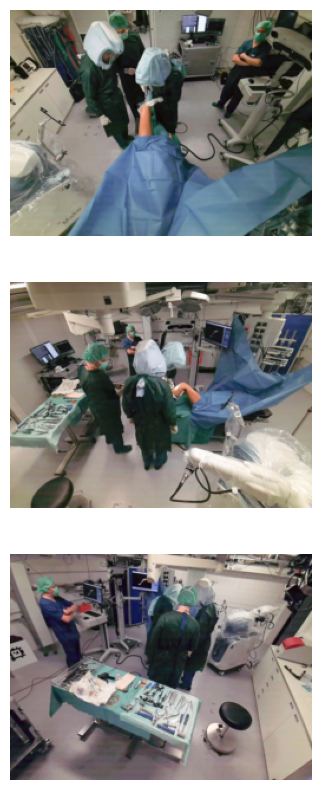

In [23]:
fig_size = np.array([3, 2]) * 5
fig, axs = plt.subplots(3, 1, figsize=fig_size)
for ii in range(3):
    image = batched_video_data_val[ii][0].img_batch[0]
    image = image[:,start:-start]
    unnormalized_image = toPILimage(revert_transform(image))
    axs[ii].imshow(unnormalized_image)
    axs[ii].axis('off')
    # axs[0, ii].set_title(f"Image {ii_to_cam_dict[ii]}")

# Prepare Masks on Image

In [24]:
# batch = batch[0]
# batch_size = len(batch.img_batch)
# key = batch.dict_key  # key for dataset
# targets = []

# for i in range(batch_size):
#     # dim=2 video_id, obj_id, frame_id
#     xx, yy = torch.where(batch.metadata.unique_objects_identifier[:,:,2] == i)
#     obj_id = batch.metadata.unique_objects_identifier[xx,yy,1]
#     targets.append({
#         "masks": batch.masks[i],
#         "labels": obj_id,
#     })
    
# loss[key](all_frame_outputs_val, targets)

batched_video_data_val.img_batch.shape = (N, B, C, H, W)  
masks_val.shape = (N, B*O, H, W)  
metadata.unique_objects_identifier = (N, B*O, 3) => [video_id, object_id, frame_id]  
obj_to_frame_idx = (N, B*O, 2) => [video_id, frame_id]  

In [25]:
def get_color_map():
    color_map = []
    for k, v in LABEL_PROJECTION_MAP['default'].items():
        # if k > 7 and v['label'] == 6:
        #     continue
        r, g, b = v['color']
        color_map.append(sv.Color(r,g,b))
    color_map = sv.ColorPalette(colors=color_map)
    return color_map

# Get color map
color_map = get_color_map()

# GT Labels
gt_labels = batched_video_data_val.metadata.unique_objects_identifier[:,:,1]

# Create subplots
figsize = np.array([2, B]) * 4
fig, axs = plt.subplots(B, 2, figsize=figsize, )

for batch_idx in range(B):
    # Unnormalize the image
    image = batched_video_data_val.img_batch[0][batch_idx]
    unnormalized_image = toPILimage(revert_transform(image))

    # GT masks
    pos = batched_video_data_val.obj_to_frame_idx[0,:,1] == batch_idx
    gt_mask = masks_val[0, pos, :, :].cpu().numpy()
    gt_class_id = gt_labels[0, pos].cpu().numpy()
    empty_bboxes = np.array([[0, 0, 0, 0]] * len(gt_class_id))

    # Gt Annotated Frame 
    gt_detections = sv.Detections(xyxy=empty_bboxes, mask=gt_mask, class_id=gt_class_id)
    mask_annotator = sv.MaskAnnotator(color=color_map)
    gt_annotated_frame = mask_annotator.annotate(
        scene=unnormalized_image.copy(),
        detections=gt_detections
    )
    # sv.plot_image(gt_annotated_frame, size=(4,4)) if B <= 10 else None

    # Prediction masks
    pred_mask = (all_frame_outputs_val[0]['pred_masks_high_res'][batch_idx].sigmoid() > 0.5).cpu().numpy()
    # pred_class_ids = best_probs.indices.numpy().astype(np.int32)
    empty_bboxes = np.array([[0, 0, 0, 0]] * len(pred_class[0]))

    # Prediction Annotated Frame
    pred_detections = sv.Detections(xyxy=empty_bboxes, mask=pred_mask, class_id=pred_class[batch_idx])
    mask_annotator = sv.MaskAnnotator(color=color_map)
    pred_annotated_frame = mask_annotator.annotate(
        scene=unnormalized_image.copy(),
        detections=pred_detections
    )
    # sv.plot_image(pred_annotated_frame, size=(4,4)) if B <= 10 else None
    axs[batch_idx,0].imshow(pred_annotated_frame, )
    axs[batch_idx,0].axis('off')
    axs[batch_idx,0].set_title(f'PRED w PQ: {pq:.4f}')

    axs[batch_idx,1].imshow(gt_annotated_frame)
    axs[batch_idx,1].axis('off')
    axs[batch_idx,1].set_title('GT')

plt.tight_layout()
plt.show()
# plt.savefig('../temp/pred_gt.png', dpi=150)

AttributeError: metadata

In [ ]:
ii_to_cam_dict = {0: 'Cam1', 1: 'Cam4', 2: 'Cam5'}
fig_size = np.array([3, 2]) * 5
fig, axs = plt.subplots(2, 3, figsize=fig_size)
for ii in range(3):
    image = batched_video_data_val.img_batch[0][ii]
    image
    unnormalized_image = toPILimage(revert_transform(image))
    axs[0, ii].imshow(unnormalized_image)
    axs[0, ii].axis('off')
    axs[0, ii].set_title(f"Image {ii_to_cam_dict[ii]}")

    axs[1, ii].imshow(gt_rgb_mask[ii])
    axs[1, ii].axis('off')
    axs[1, ii].set_title(f"GT {ii_to_cam_dict[ii]}")

plt.tight_layout()
plt.show()